In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy 
from scipy.signal import resample_poly, butter, lfilter,freqs,filtfilt,sosfilt,sosfiltfilt
from scipy.fft import fft
from matplotlib.dates import DateFormatter, AutoDateLocator


%matplotlib inline

In [2]:
#read in csv file for Pitcarin buoy
BUOY = pd.read_csv(r'C:/Users/jettr/Dropbox (University of Oregon)/Buoys/SE_Tokyo.csv')
# BUOY = pd.read_csv(r'C:\Users\kelsa\Dropbox\456Final\Buoys\SE_Tokyo.csv')


#convert month column '3' to '03' format
BUOY['MM'] = BUOY['MM'].apply(lambda x: '{:02d}'.format(x))

#drop values of height = 9999
BUOY = BUOY[BUOY['HEIGHT'] != 9999]

In [3]:
# Assigning columns
year = '#YY'  
month = 'MM'  
day = 'DD' 
hour = 'hh'  
minute = 'mm' 
second = 'ss' 

# Adding a new datetime column for year, month, day, hour, minute, and second
BUOY['Date'] = pd.to_datetime(BUOY[year].astype(str) + 
                                       BUOY[month].astype(str).str.zfill(2) + 
                                       BUOY[day].astype(str).str.zfill(2) +
                                       BUOY[hour].astype(str).str.zfill(2) +
                                       BUOY[minute].astype(str).str.zfill(2) +
                                       BUOY[second].astype(str).str.zfill(2), 
                                       format='%Y%m%d%H%M%S')
BUOY.set_index(BUOY['Date'], inplace=True)
time = BUOY['Date']


In [4]:
# Extract sample frequency "T" and "height" columns
T = BUOY['T']
height = BUOY['HEIGHT']

height_avg = np.mean(height)
BUOY['height_norm'] = height - height_avg

print('Average '+ str(height_avg))

max_height = np.max(height)
print('Max ' + str(max_height))

min_height = np.min(height)
print('Min ' + str(min_height))

Average 5824.928293006297
Max 5825.856
Min 5824.266


In [5]:
# Separate data by sampling frequency
BUOY1 = BUOY[BUOY['T'] == 1].copy()
BUOY2 = BUOY[BUOY['T'] == 2].copy()
BUOY3 = BUOY[BUOY['T'] == 3].copy()

# Reset the index for each DataFrame
BUOY1.reset_index(drop=True, inplace=True)
BUOY2.reset_index(drop=True, inplace=True)
BUOY3.reset_index(drop=True, inplace=True)

BUOY1.set_index(BUOY1['Date'], inplace=True)
time1 = BUOY1['Date']
BUOY1.drop(columns=['Date'], inplace=True)

BUOY2.set_index(BUOY2['Date'], inplace=True)
time2 = BUOY2['Date']
BUOY2.drop(columns=['Date'], inplace=True)

BUOY3.set_index(BUOY3['Date'], inplace=True)
time3 = BUOY3['Date']
BUOY3.drop(columns=['Date'], inplace=True)

BUOY.drop(columns=['Date'], inplace=True)

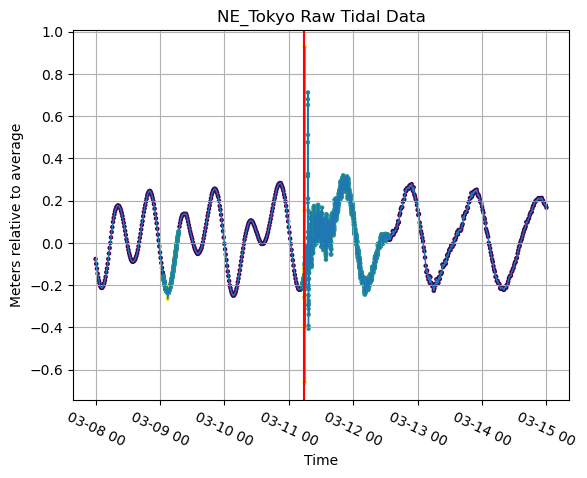

In [9]:
# Plot data
cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, 3)))
plt.figure()
plt.title('NE_Tokyo Raw Tidal Data')
plt.xlabel('Time')
plt.ylabel('Meters relative to average')
plt.plot(time, BUOY['height_norm'], linewidth=1)
plt.axvline(pd.Timestamp('2011-03-11 05:46:24'), c='red')
plt.scatter(time, BUOY['height_norm'], c=BUOY['T'], cmap=cmap, s=5)
#plt.colorbar()

# Customize x-axis ticks
plt.gca().xaxis.set_major_locator(AutoDateLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%m-%d %H'))
plt.xticks(rotation=-25)  # Rotate x-axis labels for better readability

plt.grid()
plt.show()


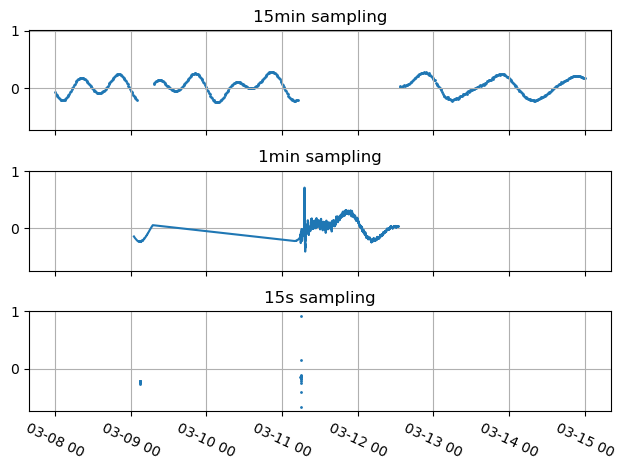

In [10]:
# Create subplots
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)

# Scatter plot for BUOY1
axs[0].scatter(BUOY1.index, BUOY1['height_norm'], s=1)
axs[0].set_title('15min sampling')
axs[0].grid()

# Scatter plot for BUOY2
axs[1].plot(BUOY2.index, BUOY2['height_norm'])
axs[1].set_title('1min sampling')
axs[1].grid()

# Scatter plot for BUOY3
axs[2].scatter(BUOY3.index, BUOY3['height_norm'], s=1)
axs[2].set_title('15s sampling')
axs[2].grid()

plt.gca().xaxis.set_major_locator(AutoDateLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%m-%d %H'))
plt.xticks(rotation=-25)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [11]:
# Resample the 'HEIGHT' column to 1-minute frequency
resamp = BUOY['height_norm'].resample('15S').mean()

# Optionally, fill missing values using linear interpolation
resamp = resamp.interpolate(method='linear')

# Create a DataFrame from the resampled Series
resamp_df = pd.DataFrame(resamp)

# Assign column names to the DataFrame
resamp_df.columns = ['height_resampled']

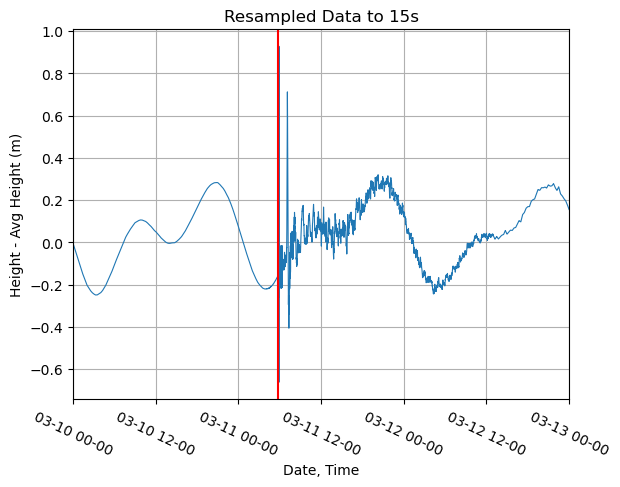

In [12]:
plt.figure()
plt.plot(resamp_df.index, resamp_df['height_resampled'], linewidth=0.8)
plt.grid()
plt.xlabel('Date, Time')
plt.ylabel('Height - Avg Height (m)')
plt.axvline(pd.Timestamp('2011-03-11 05:46:24'), c='red')
plt.title('Resampled Data to 15s')

plt.gca().xaxis.set_major_locator(AutoDateLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%m-%d %H-%M'))
plt.xticks(rotation=-25)

plt.xlim(pd.Timestamp('2011-03-10'), pd.Timestamp('2011-03-13'))

plt.show()

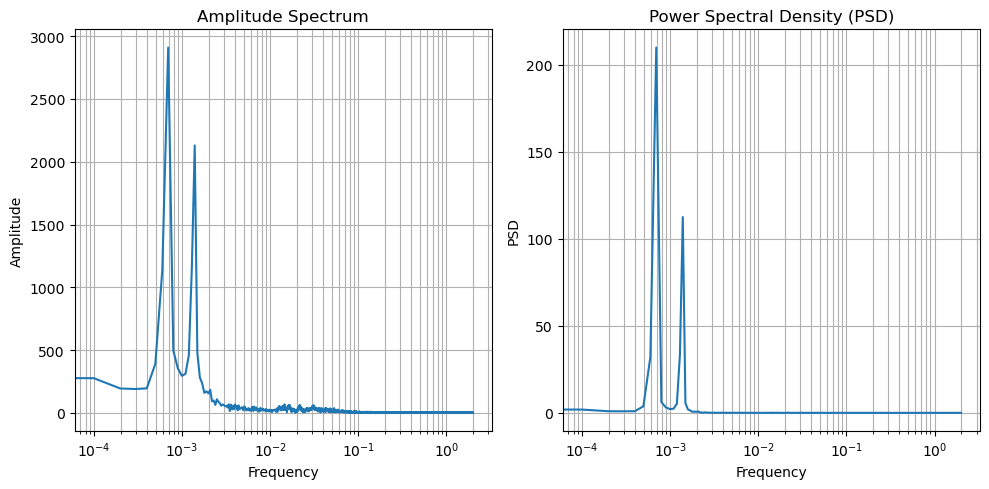

In [13]:
heights = resamp_df['height_resampled']
N = len(resamp_df['height_resampled'])
sample_freq = 4  # 4 samples per min
dt = 1 / sample_freq

BUOY_fft = np.fft.fftshift(np.fft.fft(heights))
freq = np.fft.fftshift(np.fft.fftfreq(N, dt))
amp = np.abs(BUOY_fft)

# the Power Spectral Density
PSD = (1/N) *  np.abs(BUOY_fft)**2


#Plot Amplitude Spectrum
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Amplitude Spectrum')
plt.semilogx(freq, amp)
plt.grid(which='both')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

# Plot Power Spectral Density (PSD)
plt.subplot(1, 2, 2)
plt.title('Power Spectral Density (PSD)')
plt.semilogx(freq, PSD)
plt.grid(which='both')
plt.xlabel('Frequency')
plt.ylabel('PSD')

plt.tight_layout()
plt.show()


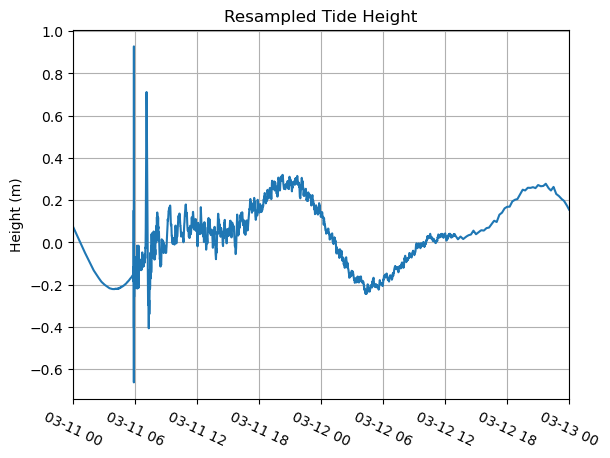

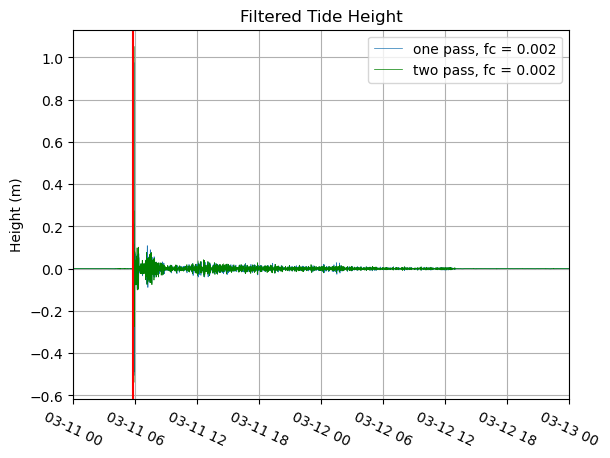

In [14]:
# Define the filter parameters
poles = 4  # Filter order
fc = 0.002  # Corner frequency in Hz
fs = 1 / 15  # 1 sample every 15 sec 

# Calculate the normalized corner frequency
fnyquist = 0.5 * fs
normalized_corner_freq = fc / fnyquist

# Design the Butterworth highpass filter
b, a = butter(poles, normalized_corner_freq, btype='high', analog=False)

# Get the frequency response
w, h = scipy.signal.freqz(b, a, worN=4096)

# Convert from angular to linear freq
f = (w) / (np.pi)
f = f * fnyquist

BUOY_filt = lfilter(b, a, heights)
BUOY_filt2 = filtfilt(b, a, heights)

plt.figure()
plt.title('Resampled Tide Height')
plt.ylabel('Height (m)')
plt.plot(resamp_df.index, heights, label='unfiltered')
plt.gca().xaxis.set_major_locator(AutoDateLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%m-%d %H'))
plt.xlim(pd.Timestamp('2011-03-11'), pd.Timestamp('2011-03-13'))
plt.xticks(rotation=-25)
plt.grid()
plt.show()



plt.figure()
plt.title('Filtered Tide Height')
plt.ylabel('Height (m)')
plt.plot(resamp_df.index, BUOY_filt, label=r'one pass, fc = %s' % fc, linewidth=0.5)
plt.plot(resamp_df.index, BUOY_filt2, label=r'two pass, fc = %s' % fc, linewidth=0.5, c='green')
plt.axvline(pd.Timestamp('2011-03-11 05:46:24'), c='red')
plt.gca().xaxis.set_major_locator(AutoDateLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%m-%d %H'))
plt.xlim(pd.Timestamp('2011-03-11'), pd.Timestamp('2011-03-13'))
plt.xticks(rotation=-25)
plt.legend()
plt.grid()
plt.show()